In [1]:
import trenchripper as tr

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import warnings
import random
import statsmodels.api as sm

from matplotlib import pyplot as plt

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

random.seed(42)
np.random.seed(42)

dask_wd = "/home/de64/scratch/de64/dask"

warnings.filterwarnings(action='once',category=UserWarning)

plt.style.use('./deaton.mplstyle')

### Load Functions

In [2]:
def compute_volume(length,width): ##spherocylinder
    volume = np.pi * ((1/4)*(width**2)*(length-width) + (1/6)*(width**3))
    return volume

def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

def get_std(plate_data,plate_map,plate_map_std_dict):
    standard_vals = []
    standard_signal = []
    for key,val in plate_map_std_dict.items():
        selected_data = np.array(plate_data[plate_map==key]).flatten()
        selected_data = selected_data[~np.isnan(selected_data)]
        working_standard_vals = [val for i in range(len(selected_data))]
        standard_vals += working_standard_vals
        standard_signal += list(selected_data)
    standard_vals = np.array(standard_vals)
    standard_signal = np.array(standard_signal)
    return standard_vals,standard_signal

def linear_regression(plate_data,plate_map,plate_map_std_dict):
    ##extract standard values
    std_vals,std_signal = get_std(plate_data,plate_map,plate_map_std_dict)
    
    ##linear regression
    reg = skl.linear_model.LinearRegression().fit(std_vals.reshape(-1,1),std_signal)
    predict = reg.predict(std_vals.reshape(-1,1))
    resid = (std_signal - predict)
    reg_uncertainty = np.sqrt(np.sum(resid**2)/(len(resid)-2))
    slope_uncertainty = reg_uncertainty/np.sqrt(np.sum((std_vals-np.mean(std_vals))**2))

    ## calculating LOQ by standard error of regression slope
    deriv = reg.coef_[0]    
    intercept = reg.intercept_
    loq = 10*(slope_uncertainty/deriv)
    print("LOQ: " + str(loq))
    
    predicted_concentrations = plate_data.apply(lambda x: (x-intercept)/deriv)
    samples_mask = ~plate_map.isin(list(plate_map_std_dict.keys()) + [np.NaN])
    all_samples_list = plate_map.values[samples_mask.values]
    all_sample_vals_list = predicted_concentrations.values[samples_mask.values]
    return all_samples_list,all_sample_vals_list

def weighted_least_squares(df,wt_row):
    df = pd.concat([df,wt_row])
    y = df['RNA/Protein']
    X = sm.add_constant(df['Instantaneous Growth Rate: Volume'])
    w = 1.0 / (df['RNA/Protein SEM']**2)

    model = sm.WLS(y, X, weights=w)
    fit   = model.fit()

    # grab params and their standard errors
    intercept, slope = fit.params
    int_se,    sl_se = fit.bse

    results = {'Intercept':   intercept,
        'Slope':       slope,
        'Intercept SEM': int_se,
        'Slope SEM':     sl_se}
    results = pd.Series(results)
    return results

## Figure S11A-D

In [3]:
nonrsector = ["A","S","U","C"]
ribo = ['rplA', 'rplB', 'rplC', 'rplD', 'rplE', 'rplF', 'rplI',\
 'rplJ', 'rplK', 'rplL', 'rplM', 'rplN', 'rplO', 'rplP', \
 'rplQ', 'rplR', 'rplS', 'rplT', 'rplU', 'rplV', 'rplW', \
 'rplX', 'rplY', 'rpmA', 'rpmB', 'rpmC', 'rpmD', 'rpmE', \
 'rpmF', 'rpmG', 'rpmH', 'rpmI', 'rpmJ', 'rpsA', 'rpsB', \
 'rpsC', 'rpsD', 'rpsE', 'rpsF', 'rpsG', 'rpsH', 'rpsI', \
 'rpsJ', 'rpsK', 'rpsL', 'rpsM', 'rpsN', 'rpsO', 'rpsP', \
 'rpsQ', 'rpsR', 'rpsS', 'rpsT', 'rpsU', 'ykgM', 'ykgO']

mori_data = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Modeling/2021_Mori_Data.csv")
mori_data["Ref Mean"] = mori_data[["Ref Replicate 1","Ref Replicate 2","Ref Replicate 3"]].mean(axis=1)
mori_data = mori_data[mori_data["Ref Mean"]>0]

## filtering our unassigned proteins
mori_data = mori_data[mori_data["Protein sector"]!="X"]

## relabeling sectors
mori_data["Protein sector"] = mori_data["Protein sector"].apply(lambda x: "NP" if x in nonrsector else "P")

## Relabel based on true ribosome sector
mori_data["Ribosome"] = (mori_data["Gene name"].isin(ribo))&(mori_data["Protein sector"] == "P")
mori_data.loc[(mori_data["Protein sector"] == "P")&(mori_data["Ribosome"]),"Protein sector"] = "R"

In [4]:
## load list of ppGpp regulated genes from a HQ dataset

significant_repression_2fold = ["A"]
significant_upregulation_2fold = ["B"]
significant_repression = ["A","C"]
significant_upregulation = ["B","D"]
not_usable = ["F","G"]

sv_data = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Modeling/Sanchez-Vazquez_2019_Data.csv")
sv_data = sv_data[~sv_data["1+2+ 10 min Category"].isin(not_usable)]

sv_data_decreased = sv_data[sv_data["1+2+ 10 min Category"].isin(significant_repression)]
sv_data_decreased_list = sv_data_decreased["Gene"].tolist()

## load list of P sector genes from Mori and Bala
p_sector_gene_list = mori_data[mori_data["Protein sector"].isin(['P','R'])]["Gene name"].tolist()

In [6]:
## Load transcriptomics over many conditions
r_lim_controls = ["r0","r0_1"]
c_lim_controls = ["c5","c0_1"]
r_lim_series = ["r0", "r1", "r2", "r3", "r4", "r5", "r0_1", "r1_1", "r2_1", "r3_1", "r4_1"]
c_lim_series = ["c5", "c1", "c2", "c3", "c4","c0_1","c1_1","c2_1","c3_1","c4_1"]
all_lim_series = r_lim_series + c_lim_series

mori_and_bala_data_raw = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Modeling/2022_Mori_and_Bala_Raw.csv")
mori_and_bala_data_raw_metadata = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Modeling/2022_Mori_and_Bala_Raw_Metadata.csv").set_index("Sample ID")

mori_and_bala_data_raw_metadata = mori_and_bala_data_raw_metadata.loc[all_lim_series]
mori_and_bala_data_raw = mori_and_bala_data_raw[["gene"] + all_lim_series]

mori_and_bala_data_raw["ppGpp Repressed"] = mori_and_bala_data_raw["gene"].isin(sv_data_decreased_list)
mori_and_bala_data_raw["P Sector"] = mori_and_bala_data_raw["gene"].isin(p_sector_gene_list)
mori_and_bala_data_raw["Ribosome"] = mori_and_bala_data_raw["gene"].isin(ribo)

mori_and_bala_data_raw["R-lim Control Fraction"] = mori_and_bala_data_raw[r_lim_controls].mean(axis=1)
mori_and_bala_data_raw["C-lim Control Fraction"] = mori_and_bala_data_raw[c_lim_controls].mean(axis=1)

mori_and_bala_data_raw = mori_and_bala_data_raw[mori_and_bala_data_raw["R-lim Control Fraction"]>0]
mori_and_bala_data_raw = mori_and_bala_data_raw[mori_and_bala_data_raw["C-lim Control Fraction"]>0]

mrna_frac_rlim = mori_and_bala_data_raw[mori_and_bala_data_raw["ppGpp Repressed"]][r_lim_series].sum()
mrna_frac_clim = mori_and_bala_data_raw[mori_and_bala_data_raw["ppGpp Repressed"]][c_lim_series].sum()
mrna_frac = mori_and_bala_data_raw[mori_and_bala_data_raw["ppGpp Repressed"]][all_lim_series].sum()

mrna_frac_psector_rlim = mori_and_bala_data_raw[mori_and_bala_data_raw["P Sector"]][r_lim_series].sum()
mrna_frac_psector_clim = mori_and_bala_data_raw[mori_and_bala_data_raw["P Sector"]][c_lim_series].sum()
mrna_frac_psector = mori_and_bala_data_raw[mori_and_bala_data_raw["P Sector"]][all_lim_series].sum()

mrna_frac_ribo_rlim = mori_and_bala_data_raw[mori_and_bala_data_raw["Ribosome"]][r_lim_series].sum()
mrna_frac_ribo_clim = mori_and_bala_data_raw[mori_and_bala_data_raw["Ribosome"]][c_lim_series].sum()
mrna_frac_ribo = mori_and_bala_data_raw[mori_and_bala_data_raw["Ribosome"]][all_lim_series].sum()

## Load proteomics over many conditions

r_lim_proteome_controls = ["A2","H1","H5"]
c_lim_proteome_controls = ["C2"]
r_lim_proteome_series = ["A2","H1","H5","E1","E2","E3","E4"]
c_lim_proteome_series = ["C2","C3","C4","C5","C6","C7","C8","D6","D7","D8","F4","F5","F6","F7","F8"]
all_lim_proteome_series = r_lim_proteome_series + c_lim_proteome_series

### mori data raw
mori_data_raw = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Modeling/2021_Mori_Data_Raw.csv")
mori_data_raw_metadata = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Modeling/2021_Mori_Data_Raw_Metadata.csv").set_index("Sample ID")

mori_data_raw = mori_data_raw[["Gene name"] + all_lim_proteome_series]
mori_data_raw_metadata = mori_data_raw_metadata.loc[all_lim_proteome_series]

mori_data_raw["ppGpp Repressed"] = mori_data_raw["Gene name"].isin(sv_data_decreased_list)
mori_data_raw["P Sector"] = mori_data_raw["Gene name"].isin(p_sector_gene_list)
mori_data_raw["Ribosome"] = mori_data_raw["Gene name"].isin(ribo)

mori_data_raw["R-lim Control Fraction"] = mori_data_raw[r_lim_proteome_controls].mean(axis=1)
mori_data_raw["C-lim Control Fraction"] = mori_data_raw[c_lim_proteome_controls].mean(axis=1)

mori_data_raw = mori_data_raw[mori_data_raw["R-lim Control Fraction"]>0]
mori_data_raw = mori_data_raw[mori_data_raw["C-lim Control Fraction"]>0]

proteome_frac_rlim = mori_data_raw[mori_data_raw["ppGpp Repressed"]][r_lim_proteome_series].sum()
proteome_frac_clim = mori_data_raw[mori_data_raw["ppGpp Repressed"]][c_lim_proteome_series].sum()
proteome_frac = mori_data_raw[mori_data_raw["ppGpp Repressed"]][all_lim_proteome_series].sum()

proteome_frac_psector_rlim = mori_data_raw[mori_data_raw["P Sector"]][r_lim_proteome_series].sum()
proteome_frac_psector_clim = mori_data_raw[mori_data_raw["P Sector"]][c_lim_proteome_series].sum()
proteome_frac_psector = mori_data_raw[mori_data_raw["P Sector"]][all_lim_proteome_series].sum()

proteome_frac_ribo_rlim = mori_data_raw[mori_data_raw["Ribosome"]][r_lim_proteome_series].sum()
proteome_frac_ribo_clim = mori_data_raw[mori_data_raw["Ribosome"]][c_lim_proteome_series].sum()
proteome_frac_ribo = mori_data_raw[mori_data_raw["Ribosome"]][all_lim_proteome_series].sum()

# mrna_ppGpp_fr = skl.linear_model.LinearRegression().fit(mrna_frac_ribo.values[:,np.newaxis], mrna_frac.values).coef_[0]
# mrna_psector_fr = skl.linear_model.LinearRegression().fit(mrna_frac_ribo.values[:,np.newaxis], mrna_frac_psector.values).coef_[0]

proteome_ppGpp_reg = skl.linear_model.LinearRegression().fit(proteome_frac_ribo.values[:,np.newaxis], proteome_frac.values)
proteome_psector_reg = skl.linear_model.LinearRegression().fit(proteome_frac_ribo.values[:,np.newaxis], proteome_frac_psector.values)

proteome_ppGpp_intercept = proteome_ppGpp_reg.intercept_
proteome_psector_intercept = proteome_psector_reg.intercept_

proteome_ppGpp_inv_fr = proteome_ppGpp_reg.coef_[0]
proteome_psector_inv_fr = proteome_psector_reg.coef_[0]

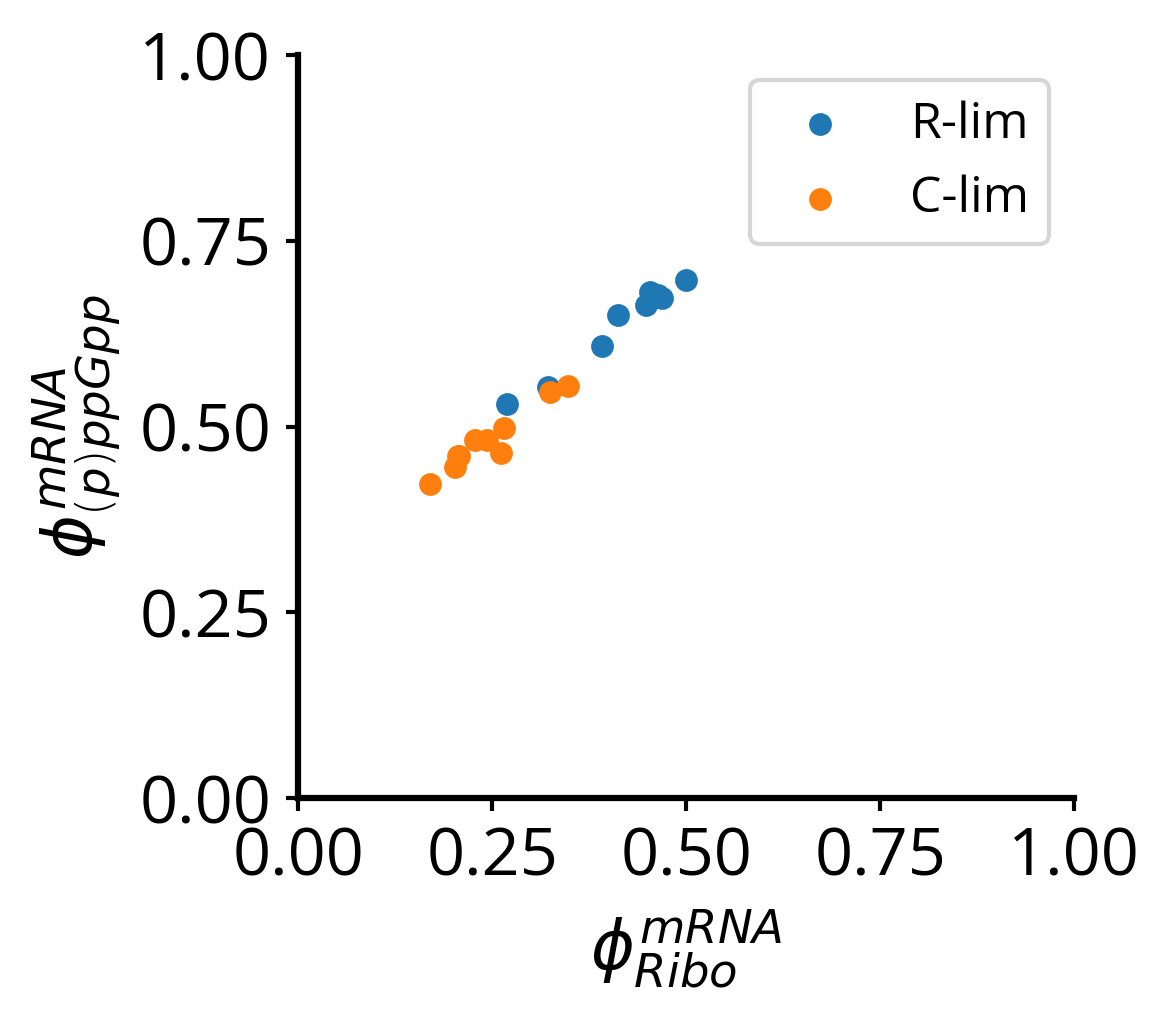

In [7]:
fig = plt.figure(figsize=(4,3.5))
ax = plt.subplot(1,1,1)
plt.scatter(mrna_frac_ribo_rlim,mrna_frac_rlim,s=20,label="R-lim")
plt.scatter(mrna_frac_ribo_clim,mrna_frac_clim,s=20,label="C-lim")

##aesthetics

plt.ylabel(r"$\phi^{mRNA}_{(p)ppGpp}$", fontsize=16)
plt.xlabel(r"$\phi^{mRNA}_{Ribo}$", fontsize=16)

ax.set_yticks(ticks=[0,.25,0.50,0.75,1.0], minor=False)
ax.set_xticks(ticks=[0,0.25,0.50,0.75,1.0], minor=False)
# ax.set_xticks(ticks=[0.25,0.50,0.75,1.0], labels=[], minor=True)

# ax.set_xticks(ticks=[0,0.5,1],labels=["0","0.5","1"],minor=False)
# ax.set_xticks(ticks=[0.25,0.75],labels=[],minor=True)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(fontsize=12)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, length=3)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)
# Remove top and right spines
sns.despine(right=True, top=True)
sns.despine()

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S11/fR_plot_mRNA_ppGpp.png",dpi=500,transparent=True,bbox_inches="tight")

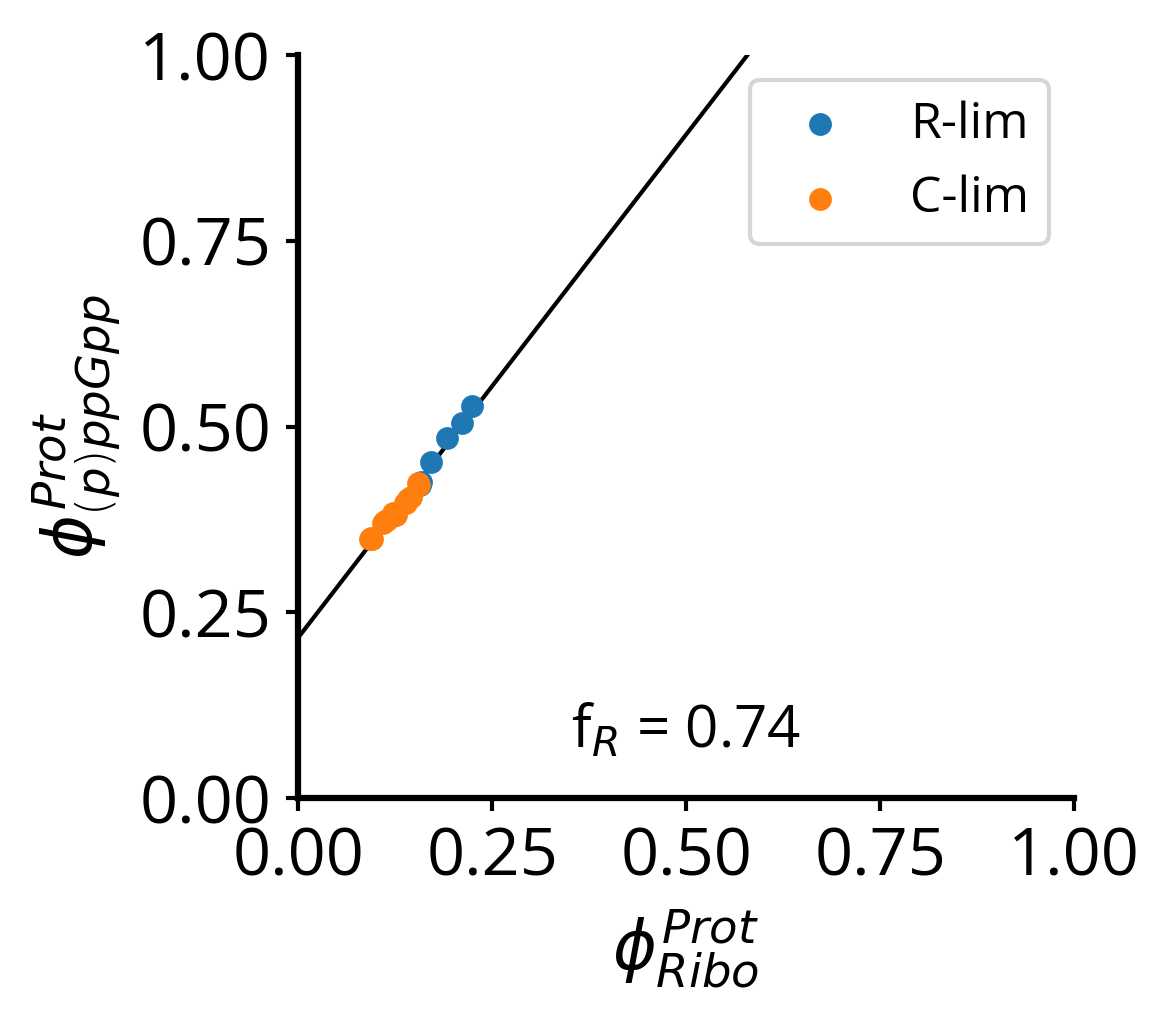

In [8]:
fig = plt.figure(figsize=(4,3.5))
ax = plt.subplot(1,1,1)

line_linspace = np.linspace(0,1)

plt.scatter(proteome_frac_ribo_rlim,proteome_frac_rlim,s=20,label="R-lim")
plt.scatter(proteome_frac_ribo_clim,proteome_frac_clim,s=20,label="C-lim")
plt.plot(line_linspace,line_linspace*proteome_ppGpp_inv_fr + proteome_ppGpp_intercept,color="black",zorder=-15)

##aesthetics

plt.ylabel(r"$\phi^{Prot}_{(p)ppGpp}$", fontsize=16)
plt.xlabel(r"$\phi^{Prot}_{Ribo}$", fontsize=16)

ax.set_yticks(ticks=[0,.25,0.50,0.75,1.0], minor=False)
ax.set_xticks(ticks=[0,0.25,0.50,0.75,1.0], minor=False)
# ax.set_xticks(ticks=[0.25,0.50,0.75,1.0], labels=[], minor=True)

# ax.set_xticks(ticks=[0,0.5,1],labels=["0","0.5","1"],minor=False)
# ax.set_xticks(ticks=[0.25,0.75],labels=[],minor=True)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(fontsize=12)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, length=3)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)

ax.text(0.5, 0.05, "f$_{R}$ = " + f"{1/proteome_ppGpp_inv_fr:.2f}", transform=ax.transAxes, fontsize=14, ha='center', va='bottom')

# Remove top and right spines
sns.despine(right=True, top=True)
sns.despine()

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S11/fR_plot_Prot_ppGpp.png",dpi=500,transparent=True,bbox_inches="tight")

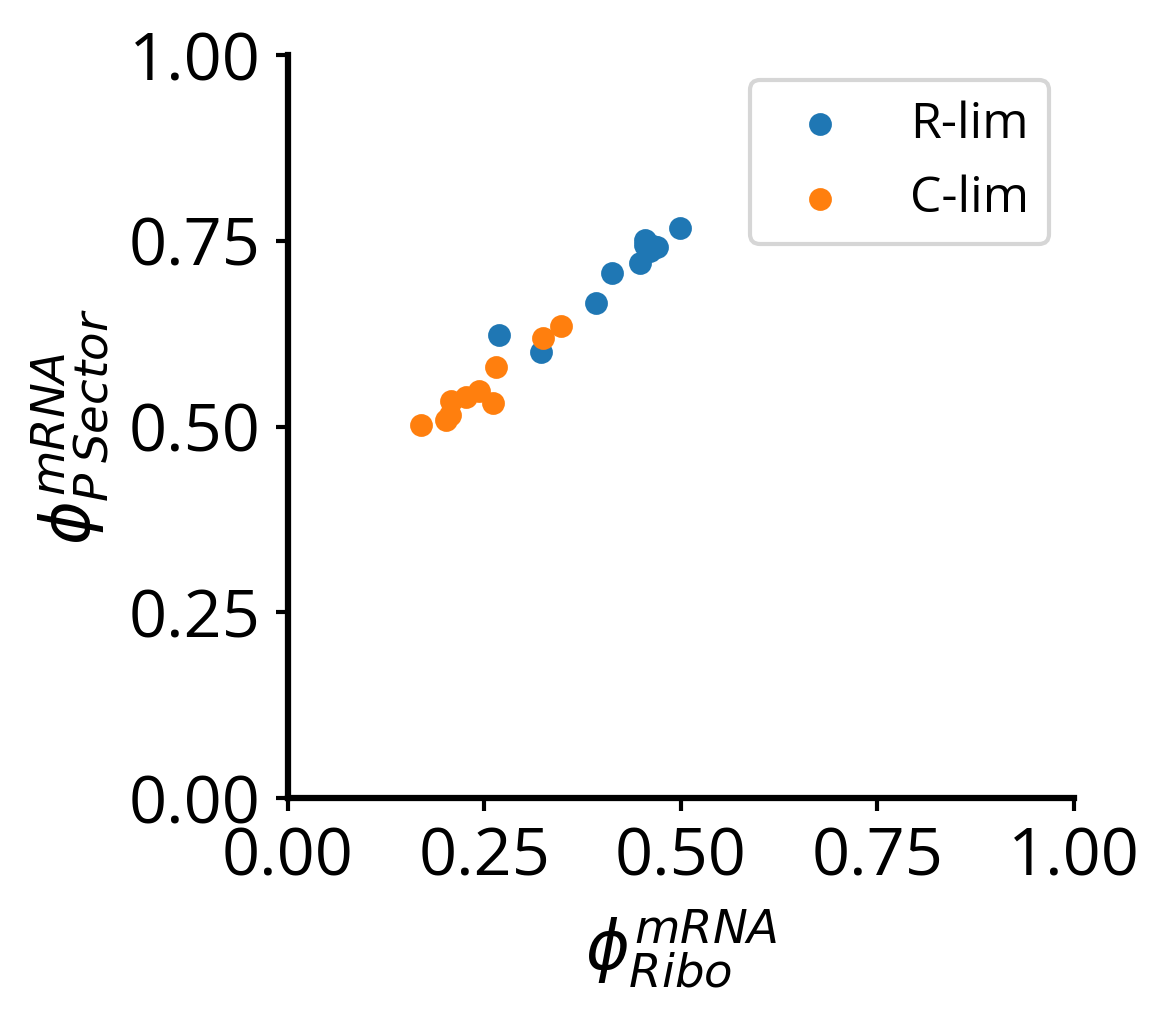

In [9]:
fig = plt.figure(figsize=(4,3.5))
ax = plt.subplot(1,1,1)
plt.scatter(mrna_frac_ribo_rlim,mrna_frac_psector_rlim,s=20,label="R-lim")
plt.scatter(mrna_frac_ribo_clim,mrna_frac_psector_clim,s=20,label="C-lim")

##aesthetics

plt.ylabel(r"$\phi^{mRNA}_{P\:Sector}$", fontsize=16)
plt.xlabel(r"$\phi^{mRNA}_{Ribo}$", fontsize=16)

ax.set_yticks(ticks=[0,.25,0.50,0.75,1.0], minor=False)
ax.set_xticks(ticks=[0,0.25,0.50,0.75,1.0], minor=False)
# ax.set_xticks(ticks=[0.25,0.50,0.75,1.0], labels=[], minor=True)

# ax.set_xticks(ticks=[0,0.5,1],labels=["0","0.5","1"],minor=False)
# ax.set_xticks(ticks=[0.25,0.75],labels=[],minor=True)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(fontsize=12)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, length=3)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)
# Remove top and right spines
sns.despine(right=True, top=True)
sns.despine()

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S11/fR_plot_mRNA_psector.png",dpi=500,transparent=True,bbox_inches="tight")

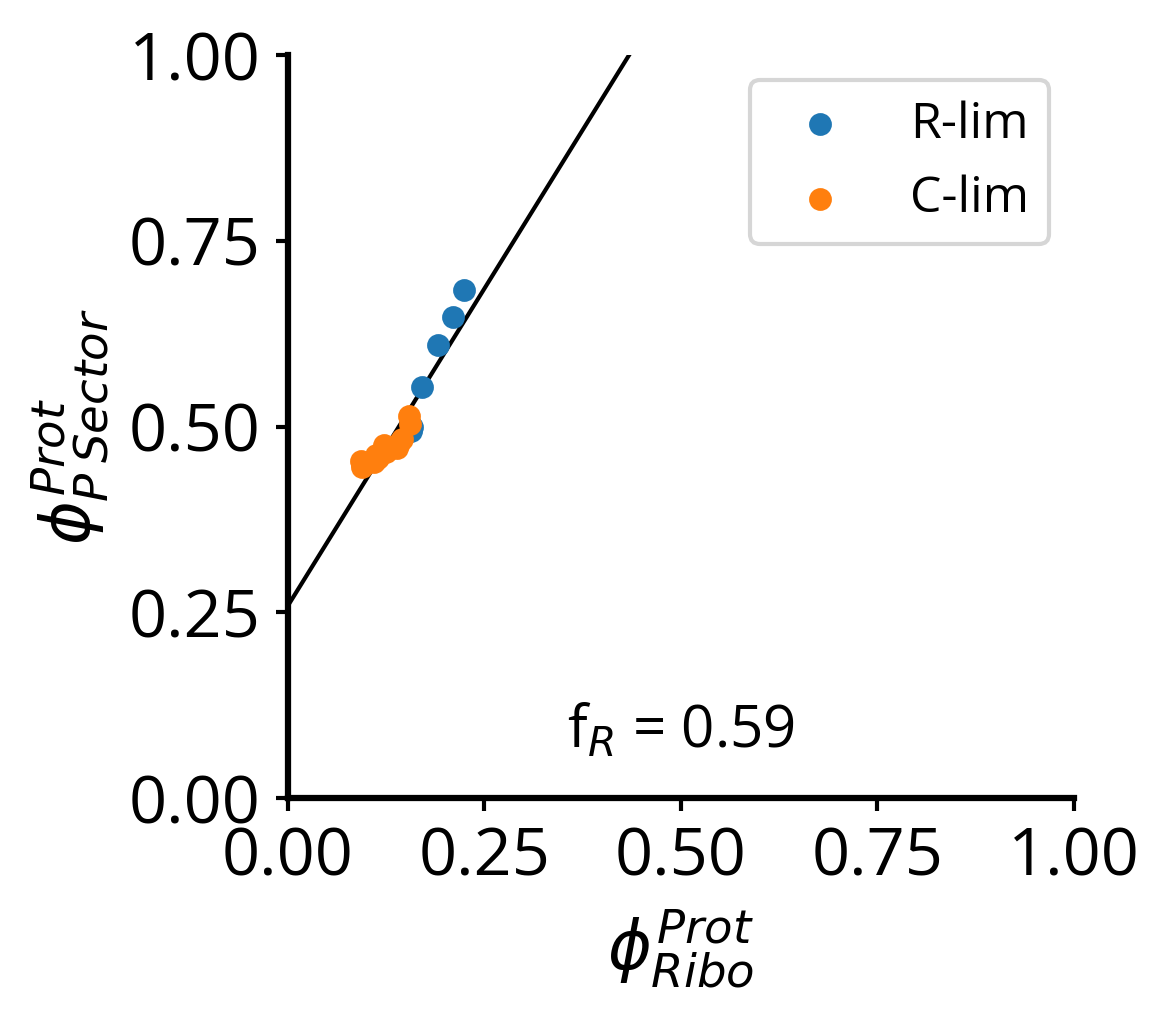

In [10]:
fig = plt.figure(figsize=(4,3.5))
ax = plt.subplot(1,1,1)
plt.scatter(proteome_frac_ribo_rlim,proteome_frac_psector_rlim,s=20,label="R-lim")
plt.scatter(proteome_frac_ribo_clim,proteome_frac_psector_clim,s=20,label="C-lim")
plt.plot(line_linspace,line_linspace*proteome_psector_inv_fr + proteome_psector_intercept,color="black",zorder=-15)

##aesthetics

plt.ylabel(r"$\phi^{Prot}_{P\:Sector}$", fontsize=16)
plt.xlabel(r"$\phi^{Prot}_{Ribo}$", fontsize=16)

ax.set_yticks(ticks=[0,.25,0.50,0.75,1.0], minor=False)
ax.set_xticks(ticks=[0,0.25,0.50,0.75,1.0], minor=False)
# ax.set_xticks(ticks=[0.25,0.50,0.75,1.0], labels=[], minor=True)

# ax.set_xticks(ticks=[0,0.5,1],labels=["0","0.5","1"],minor=False)
# ax.set_xticks(ticks=[0.25,0.75],labels=[],minor=True)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(fontsize=12)

# Set spine thickness
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Adjust tick parameters
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, length=3)
ax.tick_params(axis='both', direction='out', labelsize=16, width=1, which='minor', length=3)

ax.text(0.5, 0.05, "f$_{R}$ = " + f"{1/proteome_psector_inv_fr:.2f}", transform=ax.transAxes, fontsize=14, ha='center', va='bottom')

# Remove top and right spines
sns.despine(right=True, top=True)
sns.despine()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S11/fR_plot_Prot_psector.png",dpi=500,transparent=True,bbox_inches="tight")